In [316]:
import jax
import jax.random as random
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import equinox as eqx
from jaxtyping import PRNGKeyArray, Float, Array, Int, PyTree
import jax.numpy as jnp
import numpy as np
import jaxtyping
import typeguard
import optax
from typing import Callable
from functools import partial

In [317]:
%load_ext jaxtyping
%jaxtyping.typechecker typeguard.typechecked

The jaxtyping extension is already loaded. To reload it, use:
  %reload_ext jaxtyping


In [318]:
jax.devices()

[CudaDevice(id=0)]

In [319]:
BATCH_SIZE = 64
LEARNING_RATE = 6 * 10 ** -4  # 3e-4
EPOCHES = 450
PRINT_INTERVAL = 30
SEED = 4567
FloatScalar = Float[Array, ""]
key = random.PRNGKey(SEED)

In [320]:
normalize_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=normalize_data
)
test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=normalize_data
)


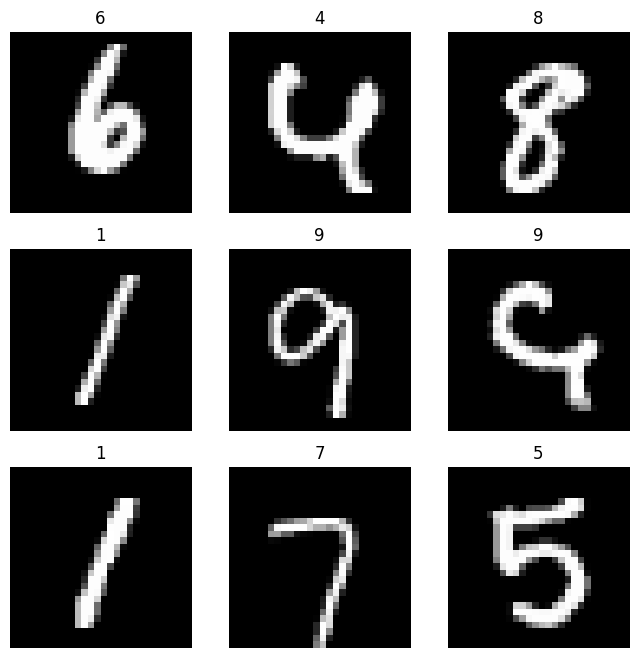

In [321]:
figure = plt.figure(figsize=(8, 8))
rows, column = 3, 3
for i in range(1, rows * column + 1):
    key, sample_key = random.split(key)
    sample_idx = int(random.randint(sample_key, shape=(1,), minval=0, maxval=len(training_dataset))[0])
    img: Image.Image
    label: str
    (img, label) = training_dataset[sample_idx]
    figure.add_subplot(rows, column, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [322]:
trainloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [323]:
_x, _y = next(iter(trainloader))
_x, _y = _x.numpy(), _y.numpy()
print(f"x.shape: {_x.shape}")
print(f"y.shape: {_y.shape}")
print(f"y values: {set(map(int, set(_y)))}")

x.shape: (64, 1, 28, 28)
y.shape: (64,)
y values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [324]:
class CNN(eqx.Module):
    layers: list

    def __init__(self, key: PRNGKeyArray):
        key1, key2, key3, key4, key5 = random.split(key, 5)
        self.layers = [
            eqx.nn.Conv2d(1, 16, kernel_size=4, key=key1),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            eqx.nn.Conv2d(16, 8, kernel_size=4, key=key5),
            eqx.nn.MaxPool2d(kernel_size=2),
            jax.nn.relu,
            jnp.ravel,
            eqx.nn.Linear(3200, 1280, key=key2),
            jax.nn.relu,
            eqx.nn.Linear(1280, 128, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(128, 64, key=key3),
            jax.nn.relu,
            eqx.nn.Linear(64, 10, key=key4),
            jax.nn.log_sigmoid
        ]

    def __call__(self, x: Float[Array, "1 28 28"]) -> Float[Array, "10"]:
        for l in self.layers:
            x = l(x)
        return x

In [325]:
key, subkey = random.split(key)
model = CNN(subkey)
print(model)

CNN(
  layers=[
    Conv2d(
      num_spatial_dims=2,
      weight=f32[16,1,4,4],
      bias=f32[16,1,1],
      in_channels=1,
      out_channels=16,
      kernel_size=(4, 4),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      use_ceil=False
    ),
    <wrapped function relu>,
    Conv2d(
      num_spatial_dims=2,
      weight=f32[8,16,4,4],
      bias=f32[8,1,1],
      in_channels=16,
      out_channels=8,
      kernel_size=(4, 4),
      stride=(1, 1),
      padding=((0, 0), (0, 0)),
      dilation=(1, 1),
      groups=1,
      use_bias=True,
      padding_mode='ZEROS'
    ),
    MaxPool2d(
      init=-inf,
      operation=<function max>,
      num_spatial_dims=2,
      kernel_size=(2, 2),
      stride=(1, 1),
      pa

In [326]:
@eqx.filter_jit
def loss(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> FloatScalar:
    y_predict = jax.vmap(model)(x)
    return optax.losses.softmax_cross_entropy_with_integer_labels(y_predict, y).mean()

In [327]:
loss_value = loss(model, _x, _y)
print(f"loss value: {loss_value}")
output = jax.vmap(model)(_x)
print(f"output.shape: {output.shape}")

loss value: 2.3080801963806152
output.shape: (64, 10)


In [328]:
@eqx.filter_jit
def accuracy(model: CNN, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> FloatScalar:
    y_predict = jax.vmap(model)(x)
    y_predict = jnp.argmax(y_predict, axis=1)
    return jnp.mean(y_predict == y)


def evaluation(model: CNN, testloader: DataLoader) -> tuple[FloatScalar, FloatScalar]:
    avg_loss = 0
    avg_accuracy = 0
    for x, y in testloader:
        x, y = x.numpy(), y.numpy()
        avg_loss += loss(model, x, y)
        avg_accuracy += accuracy(model, x, y)
    return avg_loss / len(testloader), avg_accuracy / len(testloader)

In [329]:
evaluation(model, testloader)

(Array(2.3038504, dtype=float32), Array(0.10111465, dtype=float32))

In [330]:
optimizer = optax.adamw(LEARNING_RATE)


@eqx.filter_jit
def train_step(model: CNN, opt_state: PyTree, x: Float[Array, "batch 1 28 28"], y: Int[Array, "batch"]) -> tuple[
    CNN, PyTree, FloatScalar]:
    loss_value: FloatScalar
    grad: Callable
    loss_value, grad = eqx.filter_value_and_grad(loss)(model, x, y)
    updates, opt_state = optimizer.update(grad, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


def train(model: CNN, trainloader: DataLoader, testloader: DataLoader, optim: optax.GradientTransformation,
          epoches: int, print_interval: int) -> CNN:
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    def infinite_trainloader():
        while True:
            yield from trainloader

    for epoch, (x, y) in zip(range(epoches), infinite_trainloader()):
        x, y = x.numpy(), y.numpy()
        x: np.ndarray
        y: np.ndarray
        model, opt_state, train_loss = train_step(model, opt_state, x, y)
        if (epoch % print_interval) == 0 or (epoch == epoches - 1):
            train_loss, train_accuracy = evaluation(model, trainloader)
            print(
                f"Epoch {epoch} loss: {train_loss} accuracy: {train_accuracy}"
            )
    return model

In [331]:
model = train(model, trainloader, testloader, optimizer, EPOCHES, PRINT_INTERVAL)

Epoch 0 loss: 2.2984111309051514 accuracy: 0.16006463766098022
Epoch 30 loss: 0.9134846925735474 accuracy: 0.6566997766494751
Epoch 60 loss: 0.4967413544654846 accuracy: 0.8525620102882385
Epoch 90 loss: 0.42954692244529724 accuracy: 0.8687366843223572
Epoch 120 loss: 0.3183123469352722 accuracy: 0.906549870967865
Epoch 150 loss: 0.34238067269325256 accuracy: 0.8918243646621704
Epoch 180 loss: 0.23234769701957703 accuracy: 0.9305204153060913
Epoch 210 loss: 0.20299343764781952 accuracy: 0.9381330013275146
Epoch 240 loss: 0.16774339973926544 accuracy: 0.9479610919952393
Epoch 270 loss: 0.18195632100105286 accuracy: 0.9446295499801636
Epoch 300 loss: 0.14986638724803925 accuracy: 0.9569063186645508
Epoch 330 loss: 0.12366022169589996 accuracy: 0.9627532362937927
Epoch 360 loss: 0.11890830099582672 accuracy: 0.9635860919952393
Epoch 390 loss: 0.12163611501455307 accuracy: 0.9621701836585999
Epoch 420 loss: 0.11142462491989136 accuracy: 0.965535044670105
Epoch 449 loss: 0.10526546835899353

In [332]:
evaluation(model, testloader)

(Array(0.10688587, dtype=float32), Array(0.966461, dtype=float32))

In [333]:
my_handwriting = Image.open("misleading_6.png").convert("L")
my_handwriting = np.array(my_handwriting)
my_handwriting = normalize_data(my_handwriting)
my_handwriting: torch.Tensor
my_handwriting.shape

torch.Size([1, 28, 28])

In [334]:
prediction = model(jnp.array(my_handwriting))
predicted_class = jnp.argmax(prediction)

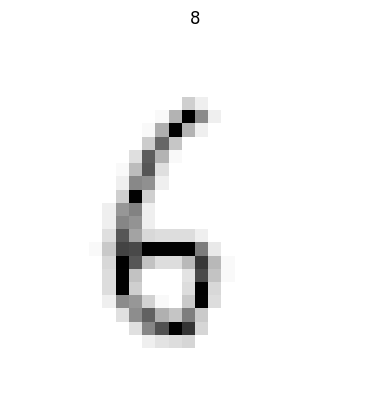

In [335]:
plt.title(predicted_class)
plt.axis("off")
_ = plt.imshow(my_handwriting.squeeze(), cmap="gray")

In [336]:
prediction = model(jnp.array(my_handwriting))

In [337]:
jnp.argmax(prediction)

Array(8, dtype=int32)

In [338]:
0.9382995963096619 - 0.9323027729988098


0.005996823310852051